# MAD Competition

Maximum differentiation (MAD) competition comes from a paper published in 2008 by Zhou Wang and Eero Simoncelli ([reprint](https://www.cns.nyu.edu/pub/lcv/wang08-preprint.pdf) from LCV website). In MAD Competition, the goal is to efficiently compare two competing models. As in all synthesis methods in `plenoptic`, the models operate on images and produce predictions related to perception. As originally conceived, the models in MAD competition are perceptual metrics: they take two images and return a scalar value that gives a perceptual distance; the smaller this number is, the more perceptually similar the metric predicts they will be. In `plenoptic`'s implementation, MAD competition can work with either perceptual metrics, which are functions that do the above, or models. In `plenoptic`, models are classes which take a single image and return a 1d or 2d representation; the perceptual distance between two images is then the distance between the two representations. By default, we use the L2-norm of the difference between these representations, but other distance metrics can be used.

For MAD competition, you specify the two models or metrics you wish to compare and a target image. MAD competition then adds some Gaussian noise to the target image (we'll call this the "initial image") and synthesizes four images: 
1. `model_1_min`: model 1 thinks this image is as similar to the target image as possible, while model 2 thinks it's as similar to the initial image as possible
2. `model_1_max`: model 1 thinks this image is as different to the target image as possible, while model 2 thinks it's as similar to the initial image as possible
1. `model_2_min`: model 2 thinks this image is as similar to the target image as possible, while model 1 thinks it's as similar to the initial image as possible
2. `model_2_max`: model 2 thinks this image is as different to the target image as possible, while model 1 thinks it's as similar to the initial image as possible

(where when I say a "model thinks", I mean the model's perceptual distance, so "model thinks is as similar as possible" means that the model's perceptual distance is as small as possible)

You can see these four images fall into two pairs and in each pair, one model thinks it's the same as the initial image, while the other thinks it's as different / similar to the target image as possible. This gives us a set of images for efficiently comparing the two models.

That's the general idea, now let's explore how to use the `MADCompetition` class for generating these images

In [1]:
import plenoptic as po
import imageio
import torch
import pyrtools as pt
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

## Basic usage

As with all our synthesis methods, we start by grabbing a target image and initalizing our models.

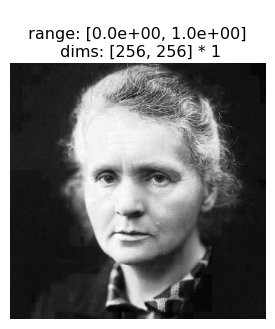

In [2]:
img = po.tools.data.load_images(['../data/curie.pgm'])
pt.imshow(img.squeeze());

To start, we'll demonstrate MAD competition as described in the paper, using two metrics: SSIM (structural similarity index, described [here](https://www.cns.nyu.edu/pub/lcv/wang03-preprint.pdf)) and MSE (mean-squared error), implementations for both of which are found in `plenoptic.metric`. 

In [3]:
model1 = po.metric.ssim
model2 = po.metric.mse

To intitialize the method, we only need to specify the target image (as a 4d tensor, as returned by `load_images`) and the two models

In [4]:
mad = po.synth.MADCompetition(img, model1, model2)

At the most basic, all we need to do is call `mad.synthesize()`, specifying the target image. Let's start with `model_1_min`, and then view the outcome (we set `store_progress=True` so that we store the synthesis progress as well as the final outcome). There are many additional possible arguments to `synthesize()` but only `synthesis_target` is required.

100%|██████████| 200/200 [00:21<00:00,  7.90it/s, gradient_norm=2.0165e-02, learning_rate=1, loss=2.5065e-01, stable_loss=1.0512e+00]
/home/billbrod/Documents/plenoptic/plenoptic/synthesize/Synthesis.py:765: UserWarning: Since at least one of your models is a metric, its representation_error will be meaningless -- it will just show the pixel-by-pixel difference. (Your loss is still meaningful, however, since it's the actual metric)
  warnings.warn("Since at least one of your models is a metric, its representation_error"
/home/billbrod/Documents/plenoptic/plenoptic/synthesize/mad_competition.py:1681: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")
/home/billbrod/Documents/plenoptic/plenoptic/tools/display.py:385: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


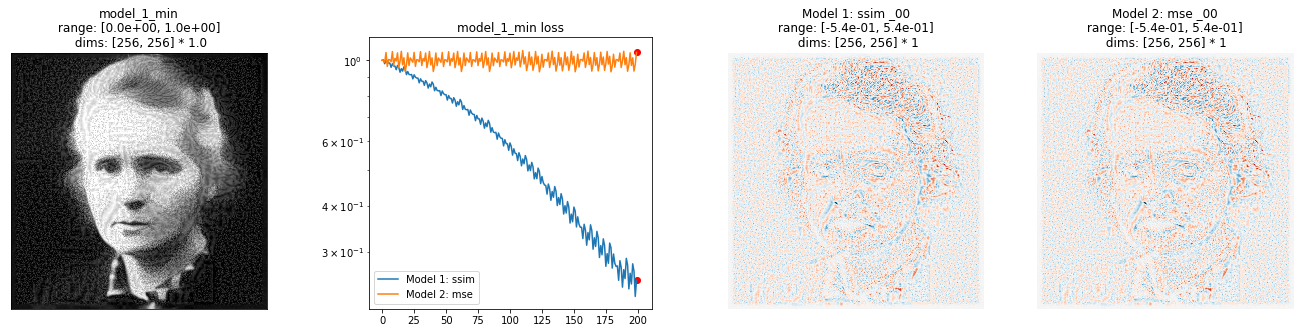

In [5]:
mad.synthesize('model_1_min', store_progress=True, max_iter=200)
fig = mad.plot_synthesis_status()

We can see from the loss plot that SSIM's loss is decreasing, while MSE's is staying roughly constant.

One of the warnings raised by this function should draw our attention "Since at least one of your models is a metric, ts representation_error will be meaningless...", and in fact we can see that the two plots on the right look identical and uninformative (they're simply giving the pixel-by-pixel difference between the target image and our synthesized image.

In order to get a more meaningful representation error plot, we'll need to use a class for our model. We don't have a class implementation for SSIM (this would be a great contribution!) but we do have one for a NLPD (normalized Laplacian pyramid distance, described [here](https://www.cns.nyu.edu/pub/lcv/laparra17-reprint.pdf)).

Note that we also switch the MSE model to a class, using `plenoptic.simul.models.naive.Identity()`. This simple model just returns a copy of the input image (since our synthesis's default distance metric is not MSE by the L2-norm of the distance, this is slightly different than above).

100%|██████████| 200/200 [00:10<00:00, 18.05it/s, gradient_norm=1.5721e-02, learning_rate=1, loss=6.5313e-01, stable_loss=1.0144e+00]
/home/billbrod/Documents/plenoptic/plenoptic/synthesize/mad_competition.py:1681: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")
/home/billbrod/Documents/plenoptic/plenoptic/tools/display.py:385: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


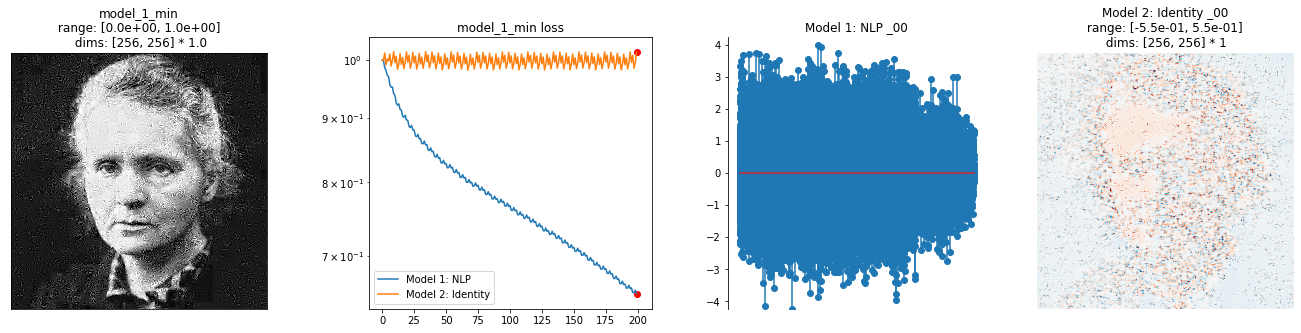

In [11]:
model1 = po.metric.NLP()
model2 = po.simul.models.naive.Identity()

mad = po.synth.MADCompetition(img, model1, model2)

mad.synthesize('model_1_min', store_progress=True, max_iter=200)
fig = mad.plot_synthesis_status()

We now see that the model 1 representation plot is a stem plot. Let's step through what that means.

When we call `model1(img)`, it returns a 3d tensor (the first two dimensions are batch and channel, which we'll ignore for now). This is what we refer to as the model's representation. The stem plot above, then, just shows the difference in the model's representation of the synthesized image and the target image. Its main use is to see if there are parts of the model where the difference is large / small, to see if some element of the optimization has gotten stuck. It doesn't look like that here -- all elements look like they're approximately the same magnitude (though some are negative and some are positive), though it's clear there's plenty more optimization to do!

In [13]:
print(model1(img))
print(model1(img).shape)

tensor([[[-0.4417, -0.3183,  0.0624,  ...,  2.6837,  1.5865,  1.7153]]])
torch.Size([1, 1, 87360])


What do these numbers mean? The Normalized Laplacian Pyramid returns activations at several scales (where scale is down-sampled by a factor of 2 from the previous), and the simple `NLP` class just flattens and concatenates them into a single vector. This is fine for optimization purposes, but means that we're throwing away information that may be useful for better understanding the optimization. For an example of how to handle that, see the `PrimaryVisualCortex` model, which also returns a flattened tensor on the forward pass, but rearranges it into more informative shapes for plotting. For more information on Laplacian pyramids, see the examples in the [pyrtools documentation](https://pyrtools.readthedocs.io/en/latest/tutorials/tutorial2.html), and for more info on how the Normalized Laplacian differs, see the [paper referenced above](https://www.cns.nyu.edu/pub/lcv/laparra17-reprint.pdf).

As described in the opening paragraph, a full set of MAD competition synthesized images consists of four images. We can make the rest by calling `synthesize()` with a different `target` argument (we use the same `MADCompetition` object; it holds onto the history of each synthesis separately, in dictionary attributes with the `_all` suffix, e.g., `mad.matched_image_all`).

100%|██████████| 200/200 [00:37<00:00,  4.43it/s, gradient_norm=3.1926e-02, learning_rate=0.0625, loss=5.2893e-01, stable_loss=9.9220e-01]


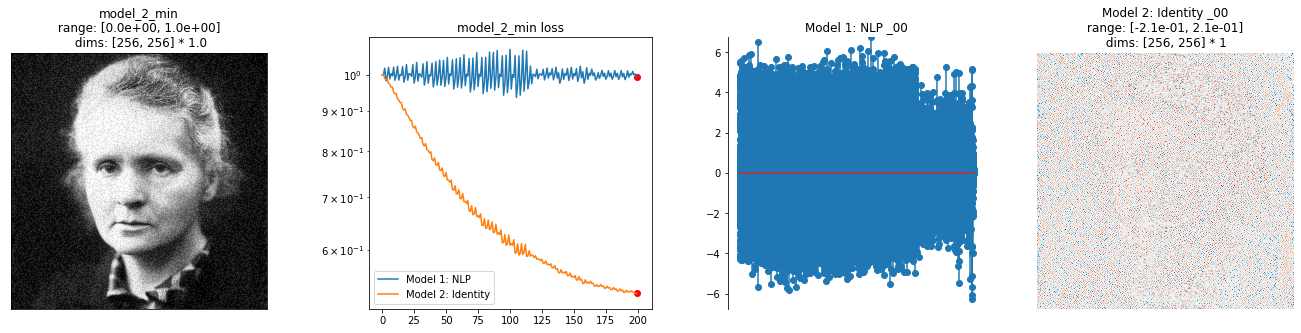

In [14]:
mad.synthesize('model_2_min', store_progress=True, max_iter=200)
fig = mad.plot_synthesis_status()

We provide a convenience function, `synthesize_all()`, which will synthesize all targets in a single call (one of its arguments determines what to do if one target has been run before; the default is to skip, but see docstring for details).

Note that `model_2_max` takes much longer than `model_1_max`. This is because on each iteration of the synthesis, we run a "stable loop", which attempts to stabilize the other model's loss, and doing this with `NLP` takes much longer than doing this with `Identity`.

In [17]:
mad.synthesize_all(store_progress=True, max_iter=200)

  1%|          | 2/200 [00:00<00:13, 15.14it/s, gradient_norm=2.3127e-02, learning_rate=1, loss=1.3926e+00, stable_loss=1.1194e+01]

Synthesis with target model_1_min has been run before, skipping
Synthesizing model_1_max


  0%|          | 0/200 [00:00<?, ?it/s, gradient_norm=3.9134e-02, learning_rate=1, loss=1.0000e+00, stable_loss=1.0000e+00]

Synthesis with target model_2_min has been run before, skipping
Synthesizing model_2_max


100%|██████████| 200/200 [01:02<00:00,  3.15it/s, gradient_norm=4.3481e-02, learning_rate=0.0312, loss=8.5339e+00, stable_loss=1.0180e+00]


We similarly provide convenience functions to view all synthesis losses

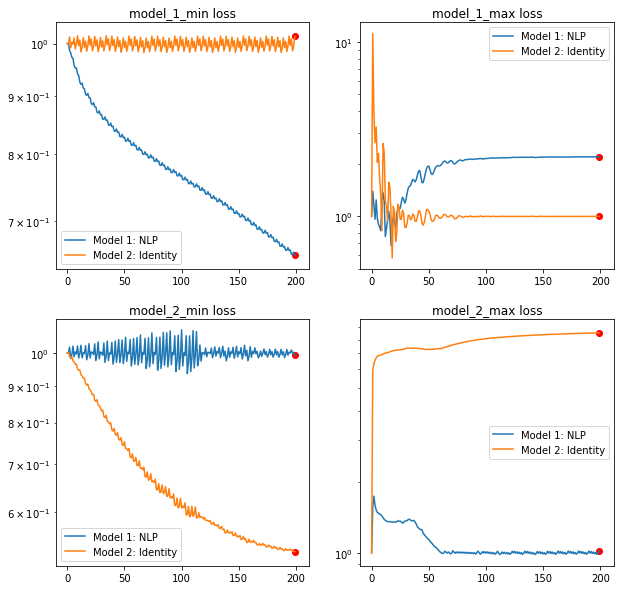

In [19]:
fig = mad.plot_loss_all()

And images

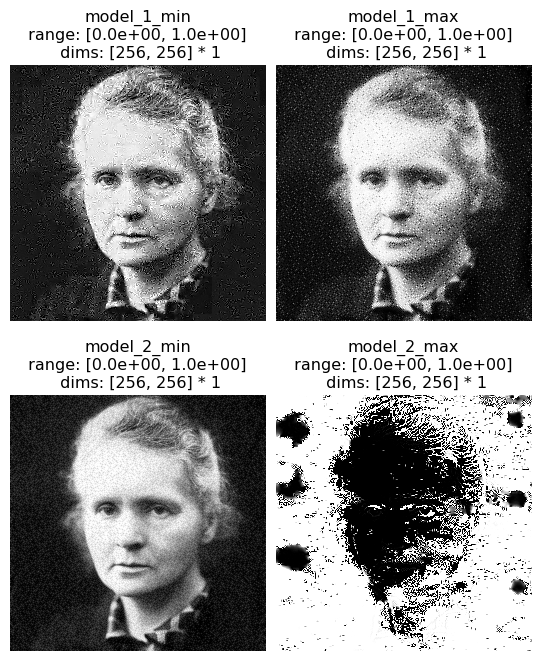

In [20]:
fig = mad.plot_synthesized_image_all()

Also to include:
 - more explanation of attributes
 - MAD specific args: initial_noise, fix_step_n_iter, norm_loss
 - `model_1/2_kwargs`
 - loss_function
 - coarse-to-fine and randomizers (reference Metamer notebook)
 - other arguments (reference Metamer)
 - resuming synthesis
 - saving/loading, and moving to another device
 - animation